In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
def save_exp(exp, path):
    import json
    with open(path, 'w') as f:
        json.dump(exp, f)
    

def uniform_cpp(partitions, cpp):
    return [cpp] * partitions

def get_all_cid(cpp):
    ids = []
    for p in range(len(cpp)):
        for c in range(cpp[p]):
            ids.append((p, c))
    
    return ids

In [4]:
def add_constant_training_params(timeline, params):
    for events in timeline:
        for event in events:
            if event['type'] == 'send':
                event['train_params'] = params

In [5]:
def generate_sync_timeline(sim, cpa, straggler_filter=lambda t,c : True):
    assert cpa <= sum(sim['client_per_partition']), f"cpa must be less than the sum of cpp {sum(sim['client_per_partition'])} > {cpa}"
    events = []
    aggregations = []
    sf = straggler_filter
    
    all_clients = get_all_cid(sim['client_per_partition'])
    while len(aggregations) < sim['naggregations']:
        last_agg = len(aggregations)
        idx = np.random.choice(len(all_clients), size=cpa, replace=False)
        selected_clients = [all_clients[i] for i in idx]
        events.append([{'type': 'fetch', 'client': c} for c in selected_clients if sf(last_agg, c)])
        events.append([{'type': 'train', 'client': c} for c in selected_clients if sf(last_agg, c)])
        events.append([{'type': 'send', 'client': c} for c in selected_clients  if sf(last_agg, c)])
        aggregations.append(aggregations[-1] + 3 if len(aggregations) > 0 else 2)
    
    return events, aggregations   

In [6]:
def plot_cpp(cpp):
    n_partitions = len(cpp)
    cmap = plt.get_cmap("viridis")
    partition_palette = [cmap(i) for i in np.linspace(0, 1, n_partitions)]
    fig = plt.figure(figsize=(min(.5 * n_partitions, 10), 2))
    ax = fig.add_subplot(111)
    ax.bar(range(n_partitions), cpp, color=partition_palette)
    ax.yaxis.get_major_locator().set_params(integer=True)
    ax.set_xticks(range(n_partitions))
    ax.set_xlabel("Partition")
    ax.set_ylabel("Clients")
    ax.set_title("Clients per Partition")
    plt.show()

In [7]:
def plot_part_contrib(timeline):
    pcmap = {}
    for events in timeline:
        for event in events:
            if event['type'] == 'send':
                p, c = event['client']
                pcmap[p] = pcmap.get(p, 0) + 1

    # Sort partitions by partition ID
    sorted_partitions = sorted(pcmap.keys())
    sorted_counts = [pcmap[p] for p in sorted_partitions]

    n_partitions = len(sorted_partitions)
    cmap = plt.get_cmap("viridis")
    partition_palette = [
        cmap(i) for i in np.linspace(0, 1, n_partitions)
    ]

    fig = plt.figure(figsize=(min(.5 * n_partitions, 20), 2))
    ax = fig.add_subplot(111)
    ax.bar(range(n_partitions), sorted_counts, color=partition_palette)
    ax.set_xticks(range(n_partitions))
    ax.set_xticklabels(sorted_partitions)
    ax.set_xlabel("Partition")
    ax.set_ylabel("Contributions")
    ax.set_title("Client Contributions per Partition")
    plt.show()

In [8]:
def plot_events(timeline, sim, highlight_ticks=[]):
    all_clients = get_all_cid(sim['client_per_partition'])
    events_by_partition = [
        [t for t, events in enumerate(timeline) for event in events if event['client'] == cid and event['type'] == 'send']
        for cid in all_clients 
    ]

    fig, ax = plt.subplots(figsize=(20, .2 * len(all_clients)))

    ax.eventplot(events_by_partition, colors=plt.cm.nipy_spectral(
        np.linspace(0, 1, len(events_by_partition)))
    )

    for tick in highlight_ticks:
        if tick > len(timeline):
            continue
        ax.axvline(x=tick, color='red', linestyle='--', linewidth=1, alpha=0.3)

    ax.set_xlabel("Time (Tick)")
    ax.set_ylabel("Partition")
    ax.set_title("Event Timeline per Partition")
    # ax.set_yticks(range(sim['npartitions']))
    ax.set_yticks(range(len(all_clients)))
    # ax.set_yticklabels([f"Client {cid}" for cid in all_clients])
    # ax.set_yticklabels([f"Partition {pid}" for pid in sorted(event_send_df['PartitionID'].unique())])
    plt.show()

In [9]:
def random_straggler_filt_fact(nclients, min_drp_prc=0, max_drp_prc=1):
    assert min_drp_prc <= max_drp_prc, "min_drp_prc must be less than or equal to max_drp_prc"
    assert min_drp_prc >= 0 and max_drp_prc <= 1, "drp_prc must be in the range [0, 1]"
    
    tick_cache = {}
        
    def filter(t, c):
        if t not in tick_cache:
            tick_cache[t] = {}
            tick_cache[t]['count'] = math.ceil(np.random.uniform(min_drp_prc, max_drp_prc) * nclients)
            tick_cache[t]['clients'] = {}

        if c in tick_cache[t]['clients']:
            return False

        if len(tick_cache[t]['clients']) == tick_cache[t]['count']:
            return True
        else:
            tick_cache[t]['clients'][c] = True
            return False

    return filter


In [16]:
def fedprox_timeline(part=30, drp = 0):
    np.random.seed(42)

    sim = {
        'npartitions': part,
        'naggregations': 10,
        'client_per_partition': uniform_cpp(part, 1),
        'proportionalKnowledge': False
    }

    tparams = {
        'learning_rate': 0.01,
        'ephocs': 20,
        'batch_size': 20,
        'optimizer': {
            'type': 'sgd',
            'momentum': 0,
            'learning_rate': 0.01,
            'weight_decay': 0  
        }
    }

    timeline, aggregations = generate_sync_timeline(sim, 10, random_straggler_filt_fact(10, drp, drp))
    add_constant_training_params(timeline, tparams)
    
    return {
        'timeline': timeline,
        'aggregations': aggregations,
        'sim': sim,
    }    

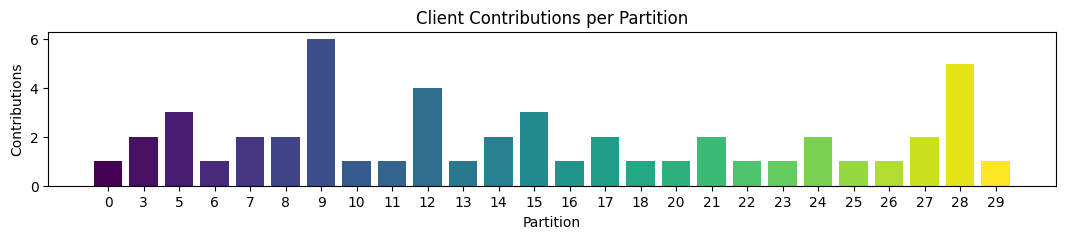

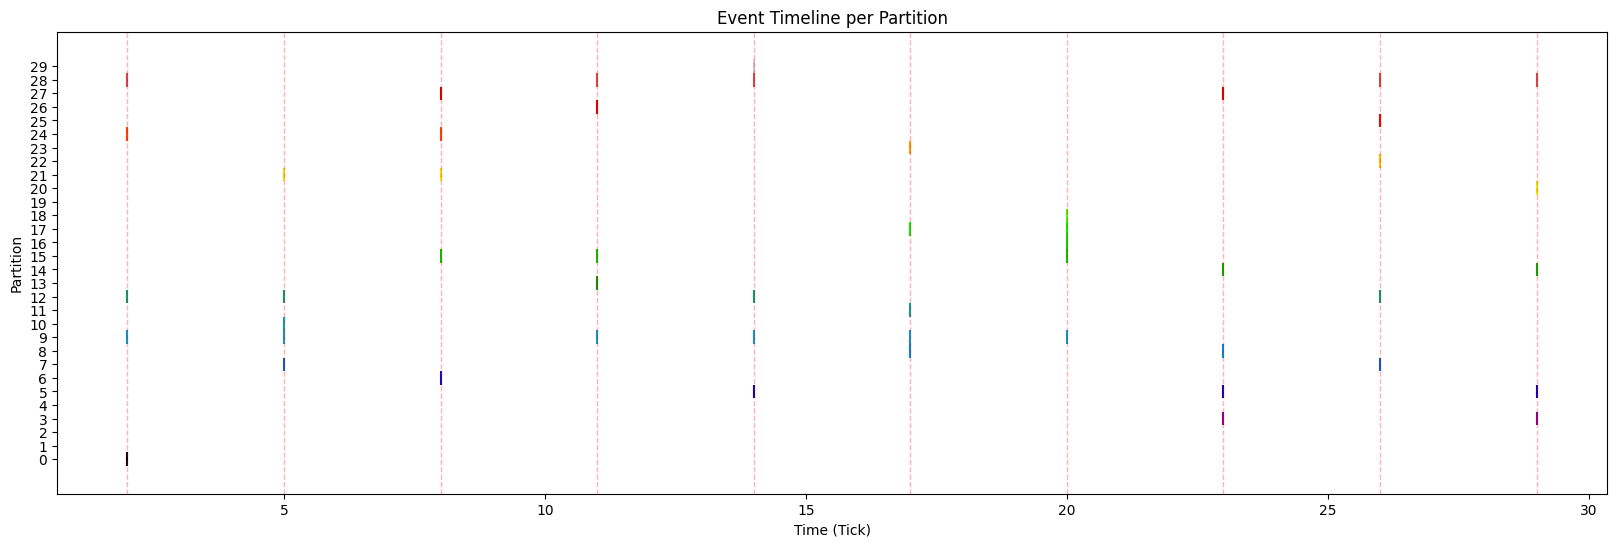

In [17]:
exp = fedprox_timeline(30, 0.5)

timeline = exp['timeline']
aggregations = exp['aggregations']
sim = exp['sim']
plot_part_contrib(timeline)
plot_events(timeline[:100], sim, aggregations)
# plot_cpp(sim['client_per_partition'])

In [12]:

# save_exp(fedprox_timeline(30, 0.0), 'fedprox-exp-drp00.json')
# save_exp(fedprox_timeline(30, 0.5), 'fedprox-exp-drp05.json')
# save_exp(fedprox_timeline(30, 0.9), 'fedprox-exp-drp09.json')

# save_exp(fedprox_timeline(1000, 0.0), 'fedprox-exp-p1000-drp00.json')
# save_exp(fedprox_timeline(1000, 0.5), 'fedprox-exp-p1000-drp05.json')
# save_exp(fedprox_timeline(1000, 0.9), 'fedprox-exp-p1000-drp09.json')
